Learning Lorenz with PA-NODE - derived by Node with bifurcation parameter. 

In [1]:
# Import the necessary packages:
from torchdiffeq import odeint
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider


#import Networkx as net
import Plot3D as plot3d


#set random seed to 107
torch.manual_seed(107)
np.random.seed(107)

# Neural ODE models

In [9]:
class Simple_FeedforwardNN(nn.Module):
    def __init__(self, input_dim, depth, width, output_dim, activation_func=nn.Tanh()):
        super(Simple_FeedforwardNN, self).__init__()

        layers = []
        previous_depth = input_dim
        for _ in range(depth):
            layers.append(nn.Linear(previous_depth, width))
            layers.append(activation_func)
            previous_depth = width

        layers.append(nn.Linear(width, output_dim))
        self.network = nn.Sequential(*layers)

        #Setting initial weights
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.2)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, x):
            out = self.network(x)
            return out

In [10]:
class Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, spatial_dim, depth, width, activation_func=nn.Tanh()):
        super().__init__(spatial_dim, depth, width, spatial_dim, activation_func)
        self.width              = width #width is number of neurons per hidden layer
        self.depth              = depth #Number of internal hidden layers
        self.variables          = spatial_dim



    def forward(self, t, x):
        out = self.network(x)
        return out


In [135]:
class NODE_Bifurcation(Simple_FeedforwardNN):
    '''
    Class that creates an autonomous Neural ODE with a fixed bifurcation parameter. 

    The bifurcation parameter must be set using the set_bif_param method.
    '''
    def __init__(self, spatial_dim, drivers, depth, width, activation_func=nn.Tanh()):
        super().__init__(spatial_dim+drivers, depth, width, spatial_dim, activation_func)
        self.width              = width #width is number of neurons per hidden layer
        self.depth              = depth #Number of internal hidden layers
        self.variables          = spatial_dim
        self.drivers           =  drivers
        self.bif_param          =  None

    def set_bif_params(self, param):
        '''
        Method to set the bifurcation parameter.

        Parameter must be a float or a torch pytorch tensor with shape: [1]
        '''
        if not torch.is_tensor(param):
            raise TypeError("Input param must be a torch pytorch tensor")
        else:
            self.bif_param = param.float()

        


    def forward(self, t, x): #x shoudl be (num_traj, spatial_dim)
        '''Takes t and x as input, where x is a pytorch tensor with shape: [trajectories, dim].'''
        
        if self.bif_param is None:
            raise ValueError("Bifurcation parameter not set. Please use the set_bif_param method to set it before calling forward.")
        
        elif not torch.is_tensor(x):
            raise TypeError("Input x must be a torch pytorch tensor with shape: [trajectories, dim]")

        else:
            r_val = self.bif_param
            input = torch.cat((x, r_val), dim=1)
            out = self.network(input) #(num_traj, spatial_dim+drivers)
            return out

In [136]:
class normalize_data:
    ''' 
    Class to normalize and denormalize data. 

    Data input shape default is (time, dim).
    '''
    
    def __init__(self, data, axis=0):
        self.data_mean = np.mean(data, axis=axis, keepdims=True)
        self.data_std = np.std(data, axis=axis, keepdims=True)

    def normalize(self, data):
        normalized_data = (data - self.data_mean) / self.data_std
        return normalized_data

    def denormalize(self, normalized_data):
        data = normalized_data * self.data_std + self.data_mean
        return data

#### Batching 
# Want output ot be (time, traj, dim)
def batch(data, t, batch_length, num_batch): # data shape (traj, dim, time) #All traj same length 
    '''
    Generates batches of data for training. 

    Input shape should be (time, traj, dim).
    '''
    data_length = data.shape[0]
    if batch_length >= data_length:
        raise ValueError("Batch length must be less than the length of the data.")
    else:
    #num_traj = data.shape[0]
        #traj_indices = np.random.randint(0, num_traj, batch_size)
        ic_indices = np.random.randint(0, data_length - batch_length, num_batch)

        batch_list = []
        batch_time_list = []

        for i in range(0, num_batch):
            batch_list.append(data[ic_indices[i]:ic_indices[i]+batch_length, :, :].float())
            batch_time_list.append(t[ic_indices[i]:ic_indices[i]+batch_length].float().requires_grad_(True))

        return batch_list, batch_time_list



In [ ]:
class Piecewise_Auto_NODE(Simple_FeedforwardNN):
    def __init__(self, spatial_dim, hidden_layers, depth, time_range, num_breakpoints, activation_func=nn.Tanh()):
        super().__init__(spatial_dim, hidden_layers, depth, spatial_dim*(num_breakpoints+1), activation_func)
        self.depth              = depth #Depth is number of neurons per hidden layer
        self.hiddenlayers       = hidden_layers #Number of internal hidden layers
        self.variables          = spatial_dim
        self.num_breakpoint     = num_breakpoints
        self.time_range         = time_range
        self.num_A              = (num_breakpoints+1)
        self.breakpoints        = torch.linspace(time_range[0], time_range[1], num_breakpoints+2) 
        self.break_params       = nn.Parameter(self.breakpoints[1:-1])
        self.k = 1  #steepness parameter for sigmoid function
    
    
    def sigmoid(self, x):
       out = torch.sigmoid(self.k*x)
       return out
    


    def forward(self, t, x):
     
        out = self.network(x).reshape(self.num_A, self.variables)

        #First interval 
        i1 = self.sigmoid(self.break_params[0] - t).unsqueeze(0)
        output = i1

        #Internal Intervals
        for i in range(0, self.break_params.shape[0]-1):
            a = self.sigmoid(t - self.break_params[i]).unsqueeze(0)
            b = self.sigmoid(self.break_params[i+1] - t).unsqueeze(0)
            c = a*b
            output = torch.concatenate([output, c])
            
        #Final interval 
        i_final = self.sigmoid(t - self.break_params[-1]).unsqueeze(0)
        output = torch.cat([output, i_final])
        indicator = output

        out2 = out*indicator
      
        #out[0] = out[0]*(t < self.break_params).float()
        #out[1] = out[1]*(t >= self.break_params).float()
        final_out = torch.sum(out2, dim=0)
        return final_out.unsqueeze(0)
    
  

# Generating Data

In [137]:
class Lorenz:
    def __init__(self, rho = lambda t: 14, sigma = 10, beta = 8/3):
        #Setting system parameters
        self.sigma = sigma
        self.beta = beta
        self.rho = rho #should be a 1D function of time

    #Differential Equation
    def f(self, t, x):
        xdot = [self.sigma*(x[1]-x[0]),
                x[0]*(self.rho(t) - x[2]) - x[1],
                x[0]*x[1] - self.beta*x[2] ]

        return np.array(xdot)

In [138]:
lorenz = Lorenz(rho = lambda t: 16)
r_vals = np.arange(10, 28, 2, dtype=np.float32)


#Generating data from Lorenz System with fixed parameters
dt = 0.01; tstart = 0; tfinal = 5
#Traj 1 
output = integ.solve_ivp(lorenz.f, t_span=(tstart, tfinal), y0=[1.0, 1.0, 1.0],
                            method = 'RK45', t_eval = np.arange(tstart, tfinal, dt))
data1 = output.y.T

#Traj 2  
output = integ.solve_ivp(lorenz.f, t_span=(tstart, tfinal), y0=[-1.0, -1.0, 1.0],
                            method = 'RK45', t_eval = np.arange(tstart, tfinal, dt))
data2 = output.y.T


In [139]:
rho = lambda t, r_val=r_vals[0]: r_val

In [140]:
r_list = []
data_list = []
for i in range(len(r_vals)):
    #Traj 3  
    lorenz = Lorenz(rho = lambda t, r_val=r_vals[i]: r_val)


    output1 = integ.solve_ivp(lorenz.f, t_span=(tstart, tfinal), y0=[1.0, 1.0, 1.0],
                                method = 'RK45', t_eval = np.arange(tstart, tfinal, dt))
    output2 = integ.solve_ivp(lorenz.f, t_span=(tstart, tfinal), y0=[-1.0, -1.0, 1.0],
                            method = 'RK45', t_eval = np.arange(tstart, tfinal, dt))
    np.stack((output1.y.T, output2.y.T), axis=1)
    r_list.append(r_vals[i]); r_list.append(r_vals[i]) 
    data_list.append(np.stack((output1.y.T, output2.y.T), axis=1))

In [141]:
len(r_list)

18

In [142]:
data_full = np.concatenate(data_list, axis=1)
data_full.shape

(500, 18, 3)

### Normalizing Data

In [143]:
norm = normalize_data(data_full.reshape(-1, 3))

In [144]:
data_norm = norm.normalize(data_full)

## Plotting 

In [ ]:
def plot_interact(index):
    #Normalised Plot
    fig = plt.figure(figsize=(6, 8))
    ax1 = fig.add_subplot(1, 1, 1, projection='3d')
    ax1.set_title('r = '+str(r_list[2*index]), fontsize=14)
    ax1.plot(xs=data_norm[:, 2*index,  0], ys=data_norm[:, 2*index, 1], zs=data_norm[:, 2*index, 2], color = 'black', linewidth = 1 )
    ax1.plot(xs=data_norm[:, 2*index + 1, 0], ys=data_norm[:, 2*index + 1, 1], zs=data_norm[:, 2*index + 1, 2], color = 'red', linewidth = 1)


    ax1.view_init(elev = 30, azim = 120)

interact(plot_interact, index=IntSlider(min=0, max=8, step=1))

In [146]:
interact(plot_interact, index=IntSlider(min=0, max=8, step=1))

interactive(children=(IntSlider(value=0, description='index', max=8), Output()), _dom_classes=('widget-interac…

<function __main__.plot_interact(index)>

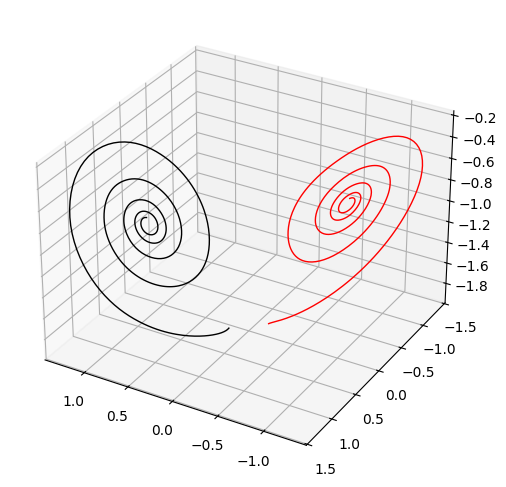

In [147]:
#Normalised Plot
fig = plt.figure(figsize=(6, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.plot(xs=data_norm[:, 0,  0], ys=data_norm[:, 0, 1], zs=data_norm[:, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=data_norm[:, 1, 0], ys=data_norm[:, 1, 1], zs=data_norm[:, 1, 2], color = 'red', linewidth = 1)


ax1.view_init(elev = 30, azim = 120)

plt.show()

# Training Neural ODE

In [148]:
model = NODE_Bifurcation(spatial_dim=3, drivers=1, depth=3, width = 30)

In [149]:
#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


#Putting data into tensor 
t_eval_tensor =  torch.tensor(np.arange(tstart, tfinal, dt))
training_data_tensor = torch.tensor(data_norm)

In [150]:
r_tensor = torch.tensor([r_list])
print(training_data_tensor[0, :, :].shape)
print(r_tensor.T.shape)

torch.Size([18, 3])
torch.Size([18, 1])


In [151]:
torch.cat((training_data_tensor[0, :, :], r_tensor.T), dim=1)

tensor([[ 0.1504,  0.1407, -1.9440, 10.0000],
        [-0.1504, -0.1407, -1.9440, 10.0000],
        [ 0.1504,  0.1407, -1.9440, 12.0000],
        [-0.1504, -0.1407, -1.9440, 12.0000],
        [ 0.1504,  0.1407, -1.9440, 14.0000],
        [-0.1504, -0.1407, -1.9440, 14.0000],
        [ 0.1504,  0.1407, -1.9440, 16.0000],
        [-0.1504, -0.1407, -1.9440, 16.0000],
        [ 0.1504,  0.1407, -1.9440, 18.0000],
        [-0.1504, -0.1407, -1.9440, 18.0000],
        [ 0.1504,  0.1407, -1.9440, 20.0000],
        [-0.1504, -0.1407, -1.9440, 20.0000],
        [ 0.1504,  0.1407, -1.9440, 22.0000],
        [-0.1504, -0.1407, -1.9440, 22.0000],
        [ 0.1504,  0.1407, -1.9440, 24.0000],
        [-0.1504, -0.1407, -1.9440, 24.0000],
        [ 0.1504,  0.1407, -1.9440, 26.0000],
        [-0.1504, -0.1407, -1.9440, 26.0000]], dtype=torch.float64)

## Single Loop 

In [153]:
model.set_bif_params(r_tensor.T)

In [155]:
#Single training loop
optimizer.zero_grad()
pred_x = odeint(model, training_data_tensor[0, :, :].float(), t_eval_tensor.float(), method='rk4', options={'step_size': dt})

loss_fn = nn.L1Loss()
train_loss = loss_fn(pred_x, training_data_tensor.float())

train_loss.backward()
optimizer.step()

print('Total Loss: ', train_loss)
print('')


Total Loss:  tensor(2.1335, grad_fn=<MeanBackward0>)



## Main Training Loop

In [174]:
batch_length = 20
num_batch = 25
num_epochs = 2500

for epoch in tqdm(range(num_epochs)):
    batch_list, batch_time_list = batch(training_data_tensor, t_eval_tensor, batch_length=batch_length, num_batch=num_batch)
    for i in range(0, num_batch):
        batch_i = batch_list[i]
        batch_time_i = batch_time_list[i]

        optimizer.zero_grad()

        #Predicting the trajectory
        pred_x = odeint(model, batch_i[0, :, :], batch_time_i, method='rk4', options={'step_size': dt})

        #Calculating loss
        loss = loss_fn(pred_x, batch_i.float()) #Error is coming from here 
        #loss_list.append(loss.item())

        #Backpropagation
        loss.backward()
        optimizer.step()
     
    
    if epoch%20==0:
            #Calculate training loss
            with torch.no_grad():
                temp_list = []
                pred_x = odeint(model, training_data_tensor[0, :, :].float(), t_eval_tensor, method='rk4', options={'step_size': dt})
                
                train_loss = loss_fn(pred_x, training_data_tensor.float())
                loss_list.append(train_loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {train_loss.item()}')

  0%|          | 1/2500 [00:02<1:54:18,  2.74s/it]

Epoch 0, Loss: 0.981464147567749


  4%|▍         | 101/2500 [01:56<44:58,  1.12s/it] 

Epoch 100, Loss: 0.9304795861244202


  8%|▊         | 201/2500 [03:42<43:49,  1.14s/it]

Epoch 200, Loss: 0.9220466017723083


 12%|█▏        | 301/2500 [05:44<47:13,  1.29s/it]

Epoch 300, Loss: 0.5783018469810486


 16%|█▌        | 401/2500 [07:42<44:53,  1.28s/it]

Epoch 400, Loss: 0.6404173970222473


 20%|██        | 501/2500 [09:44<43:24,  1.30s/it]

Epoch 500, Loss: 0.6135813593864441


 24%|██▍       | 601/2500 [11:36<38:06,  1.20s/it]

Epoch 600, Loss: 0.5411087274551392


 28%|██▊       | 701/2500 [13:26<35:42,  1.19s/it]

Epoch 700, Loss: 0.529462993144989


 32%|███▏      | 801/2500 [15:16<33:52,  1.20s/it]

Epoch 800, Loss: 0.447119802236557


 36%|███▌      | 901/2500 [17:07<32:03,  1.20s/it]

Epoch 900, Loss: 0.4513363838195801


 40%|████      | 1001/2500 [18:57<29:54,  1.20s/it]

Epoch 1000, Loss: 0.3842102289199829


 44%|████▍     | 1101/2500 [20:48<27:44,  1.19s/it]

Epoch 1100, Loss: 0.3766009211540222


 48%|████▊     | 1201/2500 [22:38<25:48,  1.19s/it]

Epoch 1200, Loss: 0.4053293764591217


 52%|█████▏    | 1301/2500 [24:29<23:52,  1.19s/it]

Epoch 1300, Loss: 0.44175979495048523


 56%|█████▌    | 1401/2500 [26:20<21:56,  1.20s/it]

Epoch 1400, Loss: 0.3019437789916992


 60%|██████    | 1501/2500 [28:11<20:24,  1.23s/it]

Epoch 1500, Loss: 0.2587435841560364


 64%|██████▍   | 1601/2500 [30:06<17:53,  1.19s/it]

Epoch 1600, Loss: 0.24462349712848663


 68%|██████▊   | 1701/2500 [31:57<16:11,  1.22s/it]

Epoch 1700, Loss: 0.23679788410663605


 72%|███████▏  | 1801/2500 [33:52<14:59,  1.29s/it]

Epoch 1800, Loss: 0.24918681383132935


 72%|███████▏  | 1808/2500 [34:00<13:01,  1.13s/it]


KeyboardInterrupt: 

## Plotting results

Text(0.5, 0, 'Epochs')

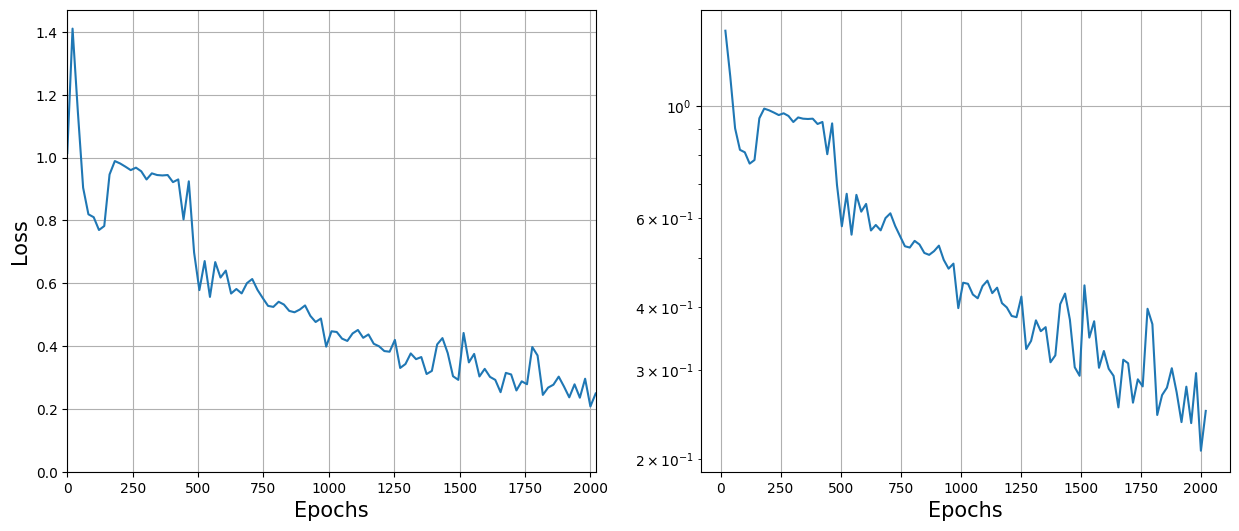

In [175]:
### Analysis  
epochs = len(loss_list)*20
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])
#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [180]:
t_Start_pred = 0; t_Final_pred = 20
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt)
node_data = odeint(model, training_data_tensor[0, :, :].float(), t_eval_pred, method='rk4', options={'step_size': dt})

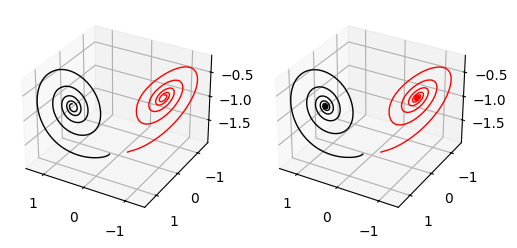

In [181]:



#Plotting results
fig = plt.figure(figsize=(6, 8))

#First Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot(xs=training_data_tensor[:, 0, 0], ys=training_data_tensor[:, 0, 1], zs=training_data_tensor[:, 0, 2], color = 'black', linewidth = 1 )
ax1.plot(xs=training_data_tensor[:, 1, 0], ys=training_data_tensor[:, 1, 1], zs=training_data_tensor[:, 1, 2], color = 'red', linewidth = 1 )

#ax1.plot(xs=node_data[:, 0].detach().numpy(), ys=node_data[:, 1].detach().numpy(), zs=node_data[:, 2].detach().numpy(), color='red', linewidth=1)
ax1.view_init(elev = 30, azim = 120)


#Second Plot 
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot(xs=node_data[:, 0, 0].detach().numpy(), ys=node_data[:, 0, 1].detach().numpy(), zs=node_data[:, 0, 2].detach().numpy(), color = 'black', linewidth = 1 )
ax2.plot(xs=node_data[:, 1, 0].detach().numpy(), ys=node_data[:, 1, 1].detach().numpy(), zs=node_data[:, 1, 2].detach().numpy(), color = 'red', linewidth = 1 )


ax2.view_init(elev = 30, azim = 120)


plt.show()

In [ ]:
def plot_interact2(index):
        #Plotting results
        fig = plt.figure(figsize=(6, 8))

        #First Plot
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot(xs=training_data_tensor[:, 2*index, 0], ys=training_data_tensor[:, 2*index, 1], zs=training_data_tensor[:, 2*index, 2], color = 'black', linewidth = 1 )
        ax1.plot(xs=training_data_tensor[:, 2*index + 1, 0], ys=training_data_tensor[:, 2*index + 1, 1], zs=training_data_tensor[:, 2*index + 1, 2], color = 'red', linewidth = 1 )
        ax1.view_init(elev = 30, azim = 120)

        #Second Plot 
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot(xs=node_data[:, 2*index, 0].detach().numpy(), ys=node_data[:, 2*index, 1].detach().numpy(), zs=node_data[:, 2*index, 2].detach().numpy(), color = 'black', linewidth = 1 )
        ax2.plot(xs=node_data[:, 2*index + 1, 0].detach().numpy(), ys=node_data[:, 2*index + 1, 1].detach().numpy(), zs=node_data[:, 2*index + 1, 2].detach().numpy(), color = 'red', linewidth = 1 )
        ax2.view_init(elev = 30, azim = 120)



In [183]:
interact(plot_interact2, index=IntSlider(min=0, max=8, step=1))

interactive(children=(IntSlider(value=0, description='index', max=8), Output()), _dom_classes=('widget-interac…

<function __main__.plot_interact2(index)>

## Bifurcation Diagram

In [ ]:
a = 1

In [ ]:
np.vectorize(lorenz.f)

In [ ]:
integ.solve_ivp(fun = np.vectorize(lorenz.f), t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', 
                t_eval = np.arange(t_Start, t_Final, dt), )




In [188]:
r_eval = np.arange(0, 28, 0.1)
initial_conditions = [[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0]]

t_Start = 0; t_Final = 250; t_Transient = 230; dt = 0.01

In [189]:
x_list = []
r_list = []
for r in tqdm(r_eval):
    lorenz.rho = lambda t: r
    
    for y0 in initial_conditions:
        output = integ.solve_ivp(fun = lorenz.f, t_span = (t_Start, t_Final), y0 = y0, method = 'RK45', t_eval = np.arange(t_Start, t_Final, dt))
        z_plane = r-1
        z = output.y[2, int(t_Transient/dt):]

        #Where does do we cross the plane z = r-1 from below 
        
        indices = np.where((z[:-1] - z_plane)*(z[1:] - z_plane) <= 0)[0]
        for idx in indices:
            x_pts = output.y[0, int(t_Transient/dt):][idx]
            r_list.append(r)
            x_list.append(x_pts)
      



100%|██████████| 280/280 [02:05<00:00,  2.24it/s]
